In [1]:
from dotenv import load_dotenv
load_dotenv()

True

# Setup

In [7]:
import json
import getpass
import os
import pandas as pd
from docx import Document as DocxDocument
from IPython.display import Image, display
from pydantic import BaseModel, Field
from typing import TypedDict, List, Annotated, Optional, Literal
from langchain import hub
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.docstore.document import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage,HumanMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AnyMessage, AIMessage

In [11]:
if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

llm = init_chat_model("gpt-4o-mini", model_provider="openai")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")


Enter API key for OpenAI:  ········


In [12]:
vector_store = InMemoryVectorStore(embeddings)

# Document loader

In [15]:
df_cities = pd.read_csv("/home/jovyan/projects/marin/delta-chatbot/notebooks/cities_per_en.csv")

In [16]:
docx = DocxDocument("/home/jovyan/projects/marin/delta-chatbot/notebooks/delta.docx")
text = "\n".join([para.text for para in docx.paragraphs if para.text.strip()])

docs = [Document(page_content=text, metadata={"source": "/content/drive/My Drive/delta.docx"})]

In [17]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [18]:
_ = vector_store.add_documents(documents=all_splits)

prompt = hub.pull("rlm/rag-prompt")

/opt/conda/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


# Functions & Classes

In [19]:
def get_city_link_by_name(persian_name: str):
    try:
        result = df_cities[df_cities['name'] == persian_name]['name_en']

        if not result.empty:
            return result.iloc[0]
        else:
            return None
    except Exception as e:
        return None

PROPERTY_TYPE_MAPPING = {
    "زمین": {"url": "store", "display": "زمین"},
    "آپارتمان موقعیت اداری": {"url": "OfficeLocationApartment", "display": "آپارتمان موقعیت اداری"},
    "باغ": {"url": "garden", "display": "باغ"},
    "باغچه": {"url": "garden", "display": "باغ"},
    "تجاری": {"url": "commercial", "display": "تجاری"},
    "مغازه": {"url": "commercial", "display": "مغازه"},
    "آپارتمان": {"url": "apartment", "display": "آپارتمان"}
}
property_types = list(PROPERTY_TYPE_MAPPING.keys())

In [20]:
def search_properties(min_meter: Optional[int] = None, max_meter: Optional[int] = None,
                      min_price: Optional[int] = None, max_price: Optional[int] = None,
                      city: Optional[str] = "tehran", elevator: Optional[bool] = None,
                      property_type: Optional[str] = "apartment") -> str:
    """
    if the user wants to buy or rent property make url with filters for city, area, price, elevator, and property type.
    """

    if not property_type:
        property_type = "apartment"
    else:
        property_type = PROPERTY_TYPE_MAPPING[property_type]["url"]
        
    print(f"search_properties_func args: city={city}, min_price={min_price}, property_type={property_type}")  # Debugging
    base_url = f"https://deltadev.ir/{city}/buy/{property_type}"

    query_params = []
    if min_meter is not None and max_meter is not None:
        query_params.append(f"meter={min_meter}-{max_meter}")
    elif min_meter is not None:
        query_params.append(f"meter={min_meter}-")
    elif max_meter is not None:
        query_params.append(f"meter=-{max_meter}")

    if min_price is not None and max_price is not None:
        query_params.append(f"price={min_price}-{max_price}")
    elif min_price is not None:
        query_params.append(f"price={min_price}-")
    elif max_price is not None:
        query_params.append(f"price=-{max_price}")

    if elevator:
        query_params.append("features=elevator")

    query_string = "?" + "&".join(query_params) if query_params else ""
    url = base_url + query_string

    filters = []
    if min_meter is not None and max_meter is not None:
        filters.append(f"{min_meter} تا {max_meter} متر")
    elif min_meter is not None:
        filters.append(f"حداقل {min_meter} متر")
    elif max_meter is not None:
        filters.append(f"حداکثر {max_meter} متر")

    if min_price is not None and max_price is not None:
        filters.append(f"بین {min_price:,} تا {max_price:,} تومان")
    elif min_price is not None:
        filters.append(f"حداقل {min_price:,} تومان")
    elif max_price is not None:
        filters.append(f"حداکثر {max_price:,} تومان")

    if elevator:
        filters.append("با آسانسور")

    if filters:
        filters_str = "، ".join(filters)
        explanation = f"با ویژگی‌هایی که گفتید ({filters_str})، می‌توانید بر روی این لینک کلیک کنید و ملک‌های مشابه را پیدا کنید: {url}"
    else:
        explanation = f"می‌توانید بر روی این لینک کلیک کنید و ملک‌های موجود را مشاهده کنید: {url}"

    return url

In [83]:
class PropertyFeatures(BaseModel):
    min_meter: Optional[int] = Field(default=None, description="Minimum square meters")
    max_meter: Optional[int] = Field(default=None, description="Maximum square meters")
    min_price: Optional[int] = Field(default=None, description="Minimum price in Tomans")
    max_price: Optional[int] = Field(default=None, description="Maximum price in Tomans")
    city: Literal[tuple(df_cities['city'])] = Field(default="other", description="City name")
    elevator: Optional[bool] = Field(default=None, description="Elevator required (True/False)")
    property_type: Literal[*property_types]= Field(default="other", description="property type") 

# Tools

In [25]:
@tool
def retrieve(query: str):
    """Retrieves relevant documents based on the last message content."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


@tool
def make_buy_url(query: str):
    """
    If user wants to buy a property, 
    Extracts property features from the last message using a structured LLM 
    and make a url based on features.
    """
    structured_llm = llm.with_structured_output(PropertyFeatures)
    property_features = structured_llm.invoke(query)
    print(property_features)

    result = search_properties(**property_features.model_dump())

    return result
    
tools = [retrieve, make_buy_url]

# Chains

In [36]:

def query_or_respond(state: MessagesState):
    """Generate tool call or respond."""
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


def generate(state: MessagesState):
    """Generates a response based on context or property search results."""
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an Real estate consultant for question-answering tasks."
        "Use the following pieces of retrieved context to answer "
        "If you got a url give it to user"
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "don't mention the source of the document only answer it"
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    response = llm.invoke(prompt)
    return {"messages": [response]}


graph_builder = StateGraph(MessagesState)
graph_builder.add_node(query_or_respond)
tool_node = ToolNode(tools)
graph_builder.add_node(tool_node)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

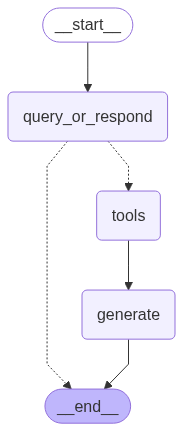

In [32]:
graph

# Usage

In [28]:
input_message = "یه خونه 70 متری حدود ۳ میلیارد توی نیویورک میخوام بخرم"

for step in graph.stream(
    {"messages": [{"role": "human", "content": input_message}]},
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

یه خونه 70 متری حدود ۳ میلیارد توی نیویورک میخوام بخرم
================================== Ai Message ==================================
Tool Calls:
  make_buy_url (call_TRWAhErSTLiCxGFxHGvtyoDM)
 Call ID: call_TRWAhErSTLiCxGFxHGvtyoDM
  Args:
    query: خونه 70 متری در نیویورک با قیمت حدود 3 میلیارد
min_meter=70 max_meter=70 min_price=3000000000 max_price=3000000000 city='tehran' elevator=None property_type='آپارتمان'
search_properties_func args: city=tehran, min_price=3000000000, property_type=apartment
================================= Tool Message =================================
Name: make_buy_url

https://deltadev.ir/tehran/buy/apartment?meter=70-70&price=3000000000-3000000000
================================== Ai Message ==================================

متأسفانه اطلاعاتی درباره قیمت‌ها و خرید ملک در نیویورک ندارم. اما می‌توانید به وب‌سایت‌های معتبر و مشاورین املاک مراجعه کنید. برای اطلاعات بیشتر

In [37]:
input_message = "نحوه ثبت آگهی در سایت چگونه است؟"

for step in graph.stream(
    {"messages": [{"role": "human", "content": input_message}]},
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

نحوه ثبت آگهی در سایت چگونه است؟
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_lTtd7NI0yexPFwMUujSjnRGp)
 Call ID: call_lTtd7NI0yexPFwMUujSjnRGp
  Args:
    query: نحوه ثبت آگهی در سایت
================================= Tool Message =================================
Name: retrieve

("Source: {'source': '/content/drive/My Drive/delta.docx'}\nContent: برای ورود به سایت نیاز به تعریف رمزعبور دارند.\nپس ار احراز هویت می\u200cتوانند ثبت آگهی کنند.\nحساب من این کاربران مشابه تصویر زیر می\u200cباشد.\nشرح منوی کاربرمشاور آژانس :\nصفحه اصلی پروفایل : \nکاربر می\u200cتواند موجودی حساب خود را مشاهده کند و دسترسی آسان به شارژکیف پول خود را دارد.\nدر این صفحه کاربر می\u200cتواند لیست آگهی\u200cهایی که ثبت کرده است را مشاهده کند. \nاقدام به ثبت فایل فروش ملک یا اجاره ملک کند.\nنمودارهای مربوط به بازدید آگهی در یک روز ، 7 روز گشته را مشاهده کنند.\nپر بازدید

In [29]:
response = graph.invoke({
    "messages": [HumanMessage(content="یه خونه 70 متری حدود ۳ میلیارد توی نیویورک میخوام بخرم")]
})
# print(response)
# print(response["answer"])

min_meter=70 max_meter=70 min_price=3000000000 max_price=3000000000 city='tehran' elevator=None property_type='آپارتمان'
search_properties_func args: city=tehran, min_price=3000000000, property_type=apartment
